In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split
import seaborn as sns

# Using some simple classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Some results metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix 

## Step 1 - Loading data        

In [2]:
X = np.loadtxt('Processed_files/X_StandardScaler.csv', delimiter = ',')
y = np.loadtxt('Processed_Files/y_LabelEncoder.csv', delimiter = ',')

In [3]:
# Creating the train and test splits for data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle = True)

## Step 2 - Initial FastICA implementation analysis - default parameters

Comparing the results for a given classifier, for a different number of components for the FastICA DR technique
(Logistic Regression was used as the classifier)

In [4]:
# Fitting the Logistic Regression model to the original data
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Making the predictions´
preds = log_reg.predict(X_test)

# Calculating the f1 score
original_f1 = f1_score(y_test, preds, average = 'weighted')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='un

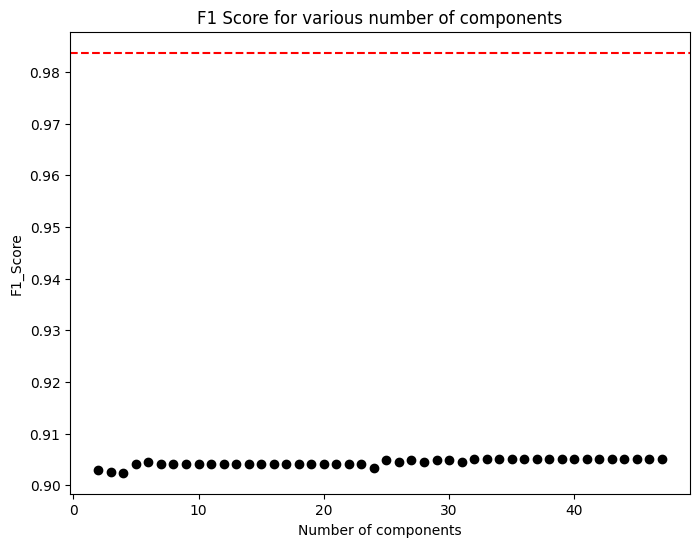

In [5]:
plt.figure(figsize=(8, 6))
plt.axes().set(xlabel='Number of components', ylabel='F1_Score', title='F1 Score for various number of components')
plt.axhline(y = original_f1, color = 'r', linestyle = '--', label = 'Original F1 Score')

# Iterating over the number of components - ICA with its default parameters
for i in range(2, X.shape[1]):

    ica = FastICA(n_components = i)
    ica.fit(X)

    # Transforming the data
    X_train_ica = ica.transform(X_train)
    X_test_ica = ica.transform(X_test)

    # Fitting the logistic regressor to the reduced data
    log_reg.fit(X_train_ica, y_train)
    preds_ica = log_reg.predict(X_test_ica)

    # Calculating the f1 score
    f1 = f1_score(y_test, preds_ica, average = 'weighted')

    plt.plot(i, f1, 'ko')


Text(0.5, 1.0, 'Original CM')

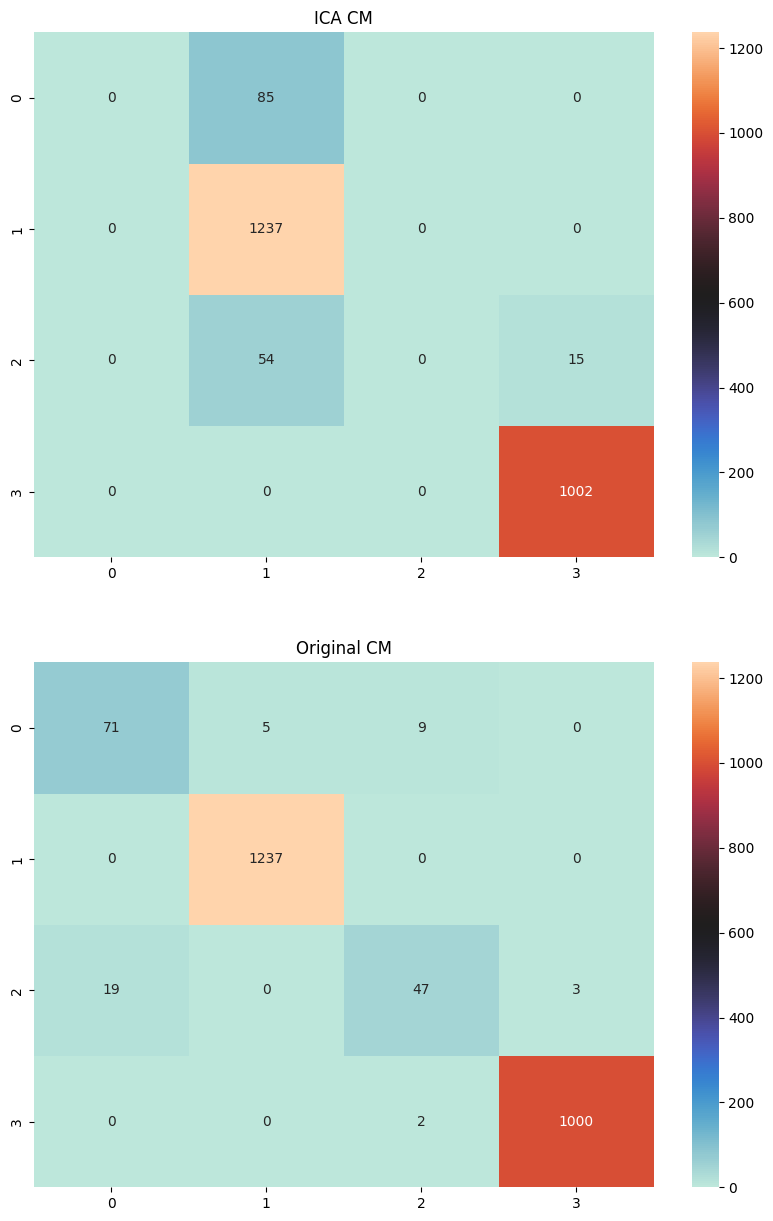

In [6]:
# Confusion matrices for both datasets
cm_ica = confusion_matrix(y_test, preds_ica)
cm_original = confusion_matrix(y_test, preds)

plt.figure(figsize = (10, 15))
plt.subplot(2, 1, 1)
sns.heatmap(cm_ica, annot=True, cmap = sns.color_palette('icefire', as_cmap = True), fmt='g')
plt.title('ICA CM')

plt.subplot(2, 1, 2)
sns.heatmap(cm_original, annot=True, cmap = sns.color_palette('icefire', as_cmap = True), fmt='g')
plt.title('Original CM')



## Step 3 - Comparative analysis + optimisation process

In [7]:
from skopt import BayesSearchCV, gp_minimize 
import skopt
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from skopt.utils import use_named_args

In [8]:
# Step 1 - defining the hyperparameters' search space
search_space = []
search_space.append(skopt.space.Integer(2, 30, name = 'n_components'))
search_space.append(skopt.space.Categorical(['parallel', 'deflation'], name = 'algorithm'))
search_space.append(skopt.space.Categorical(['arbitrary-variance', 'unit-variance'], name = 'whiten'))
search_space.append(skopt.space.Categorical(['logcosh', 'exp', 'cube'], name = 'fun'))
search_space.append(skopt.space.Integer(200, 1000, name = 'max_iter'))
search_space.append(skopt.space.Real(1e-5, 1e-3, name = 'tol'))
search_space.append(skopt.space.Categorical(['eigh', 'svd'], name = 'whiten_solver'))

In [9]:
# Step 2 - defining the evaluator
@use_named_args(search_space)

def evaluate_model(**params):

    # Define the model
    model = FastICA()
    model.set_params(**params)

    # Fit the ICA to the training data
    model.fit(X)
    X_ica = model.transform(X)

    # Start the classifier
    log_reg = LogisticRegression()

    # Define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    # Evaluate the model
    result = cross_val_score(log_reg, X_ica, y, cv = cv, n_jobs = -1, scoring = 'accuracy')

    # Return the mean accuracy
    return 1.0 - result.mean()  

In [10]:
# Step 3 - conduct optimisation process
result = gp_minimize(evaluate_model, search_space, n_calls = 25, n_random_starts = 10, random_state = 42, verbose = 2)

Iteration No: 1 started. Evaluating function at random point.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:606: UserWarning: There are some small singular values, using whiten_solver = 'svd' might lead to more accurate results.
  warnings.warn(


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.3922
Function value obtained: 0.0229
Current minimum: 0.0229
Iteration No: 2 started. Evaluating function at random point.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:606: UserWarning: There are some small singular values, using whiten_solver = 'svd' might lead to more accurate results.
  warnings.warn(


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8640
Function value obtained: 0.0290
Current minimum: 0.0229
Iteration No: 3 started. Evaluating function at random point.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:606: UserWarning: There are some small singular values, using whiten_solver = 'svd' might lead to more accurate results.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.1274
Function value obtained: 0.0200
Current minimum: 0.0200
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2536
Function value obtained: 0.0674
Current minimum: 0.0200
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.1246
Function value obtained: 0.0268
Current minimum: 0.0200
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.5853
Function value obtained: 0.0670
Current minimum: 0.0200
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 2.0008
Function value obtained: 0.0670
Current minimum: 0.0200
Iteration No: 8 started. Evaluating function at random point.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:606: UserWarning: There are some small singular values, using whiten_solver = 'svd' might lead to more accurate results.
  warnings.warn(


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.2226
Function value obtained: 0.0674
Current minimum: 0.0200
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 1.2397
Function value obtained: 0.0250
Current minimum: 0.0200
Iteration No: 10 started. Evaluating function at random point.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:606: UserWarning: There are some small singular values, using whiten_solver = 'svd' might lead to more accurate results.
  warnings.warn(


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 1.5074
Function value obtained: 0.0670
Current minimum: 0.0200
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 2.0492
Function value obtained: 0.0200
Current minimum: 0.0200
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.5408
Function value obtained: 0.0407
Current minimum: 0.0200
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 2.3798
Function value obtained: 0.0200
Current minimum: 0.0200
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1.7649
Function value obtained: 0.0214
Current minimum: 0.0200
Iteration No: 15 started. Searching for 

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:606: UserWarning: There are some small singular values, using whiten_solver = 'svd' might lead to more accurate results.
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.2913
Function value obtained: 0.0670
Current minimum: 0.0200
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.9992
Function value obtained: 0.0200
Current minimum: 0.0200
Iteration No: 20 started. Searching for the next optimal point.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 14.3757
Function value obtained: 0.0200
Current minimum: 0.0200
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 4.0188
Function value obtained: 0.0291
Current minimum: 0.0200
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 12.7758
Function value obtained: 0.0672
Current minimum: 0.0200
Iteration No: 23 started. Searching for the next optimal point.


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 4.6181
Function value obtained: 0.0200
Current minimum: 0.0200
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.1595
Function value obtained: 0.0200
Current minimum: 0.0200
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.6561
Function value obtained: 0.0670
Current minimum: 0.0200


In [11]:
# Analysing the best gotten parameters
result.x

[30, 'deflation', 'unit-variance', 'exp', 237, 5.352030272517588e-05, 'svd']

In [13]:
# Using Logistic Regression
log_reg = LogisticRegression()

# Original dataset
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Reduced pca dataset to the number of components seen previously
ica = FastICA(n_components = result.x[0], algorithm = result.x[1], whiten = result.x[2], fun = result.x[3], max_iter = result.x[4], tol = result.x[5], whiten_solver = result.x[6])
ica.fit(X_train)
X_ica_train = ica.transform(X_train)
X_ica_test = ica.transform(X_test)
log_reg.fit(X_ica_train, y_train)
y_pred_ica = log_reg.predict(X_ica_test)

# Metrics for both dastasets
f1_original = f1_score(y_test, y_pred, average = 'weighted')
f1_pca = f1_score(y_test, y_pred_ica, average = 'weighted')
print(f'F1 Score for all variables: {f1_original}')
print(f'F1 Score for {result.x[0]} variables: {f1_pca}')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score for all variables: 0.9837227680533817
F1 Score for 30 variables: 0.9789695101855843


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Making now a comparison with multiple different methods

In [14]:
# Loading each classifier (with their default hyperparameters)
svm = SVC()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
nb = GaussianNB()
log_reg = LogisticRegression()

In [16]:
# Fitting and applying all classifiers to the original sized dataset
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
nb.fit(X_train, y_train)
log_reg.fit(X_train, y_train)

# Predicting the results of the test set
y_pred_svm = svm.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)
y_pred_nb = nb.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)

# Calculating the metrics for each classifier
f1_svm = f1_score(y_test, y_pred_svm, average = 'weighted')
f1_rf = f1_score(y_test, y_pred_rf, average = 'weighted')
f1_gb = f1_score(y_test, y_pred_gb, average = 'weighted')
f1_nb = f1_score(y_test, y_pred_nb, average = 'weighted')
f1_log_reg = f1_score(y_test, y_pred_log_reg, average = 'weighted')

# Storing the metrics under a dataframe
metrics = pd.DataFrame(columns = ['N_vars', 'SVM', 'RF', 'GB', 'NB', 'LogReg'])
metrics.loc[0] = ['All', f1_svm, f1_rf, f1_gb, f1_nb, f1_log_reg]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# Fitting and applying all classifiers to the reduced dataset
svm.fit(X_ica_train, y_train)
rf.fit(X_ica_train, y_train)
gb.fit(X_ica_train, y_train)
nb.fit(X_ica_train, y_train)
log_reg.fit(X_ica_train, y_train)

# Predicting the results of the test set
y_pred_svm_ica = svm.predict(X_ica_test)
y_pred_rf_ica = rf.predict(X_ica_test)
y_pred_gb_ica = gb.predict(X_ica_test)
y_pred_nb_ica = nb.predict(X_ica_test)
y_pred_log_reg_ica = log_reg.predict(X_ica_test)

# Calculating the metrics for each classifier
f1_svm_ica = f1_score(y_test, y_pred_svm_ica, average = 'weighted')
f1_rf_ica = f1_score(y_test, y_pred_rf_ica, average = 'weighted')
f1_gb_ica = f1_score(y_test, y_pred_gb_ica, average = 'weighted')
f1_nb_ica = f1_score(y_test, y_pred_nb_ica, average = 'weighted')
f1_log_reg_ica = f1_score(y_test, y_pred_log_reg_ica, average = 'weighted')

# Storing the metrics under a dataframe
metrics.loc[1] = [result.x[0], f1_svm_ica, f1_rf_ica, f1_gb_ica, f1_nb_ica, f1_log_reg_ica]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
metrics

,N_vars,SVM,RF,GB,NB,LogReg
0,All,0.975198,0.987282,0.990669,0.978652,0.983723
1,30.0,0.971433,0.981971,0.980090,0.940203,0.978970
